In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from lib.tf_util.systems import system_from_str
from train_dsn import train_dsn
import seaborn as sns
import pandas as pd

from util import fct_integrals as integrals
from util import tf_integrals as tf_integrals

from util import fct_mf as mf



In [2]:
TIF_flow_type = 'PlanarFlowLayer';
nlayers = 4;
flow_dict = {'latent_dynamics':None, \
             'TIF_flow_type':TIF_flow_type, \
             'repeats':nlayers, \
             'scale_layer':True};

n = 1000;
k_max = 10;
c_init_order = 0;
lr_order = -3;
random_seed = 0;
min_iters = 200;
max_iters = 1000;
check_rate = 100;
dir_str = 'LRRNN';

def compute_bistable_mu(Sini, ics_0, ics_1):
    ### Set parameters

    Mm = 3.5      # Mean of m
    Mn = 1.       # Mean of n
    Mi = 0.       # Mean of I

    Sim = 1.      # Std of m
    Sin = 1.      # Std of n
    Sip = 1.      # Std of input orthogonal to m and n, along h (see Methods)

    g = 0.8
    tol = 1e-10;
    
    eps = 0.2;
    
    ParVec = [Mm, Mn, Mi, Sim, Sin, Sini, Sip];
    ys0, count = mf.SolveStatic(ics_0, g, ParVec, eps, tol);
    ys1, count = mf.SolveStatic(ics_1, g, ParVec, eps, tol);
    
    ss0 = ys0[-1,2];
    ss1 = ys1[-1,2];
    mu = np.array([ss0, ss1]);
    return mu;

In [3]:
system_str = 'rank1_rnn';

K = 1;
M = n;
behavior_str = 'bistable';
T = 10;
ics_0 = np.array([5., 5., 5.], np.float64);
ics_1 = np.array([-5., 5., -5.], np.float64);

Ics_0 = np.tile(np.expand_dims(np.expand_dims(ics_0, 0), 1), [K,M,1]);
Ics_1 = np.tile(np.expand_dims(np.expand_dims(ics_1, 0), 1), [K,M,1]);

system_class = system_from_str(system_str);
system = system_class(T, Ics_0, Ics_1, behavior_str);

Sini1 = 0.5;
mu1 = compute_bistable_mu(Sini1, ics_0, ics_1);
print('mu1', mu1);
Sini2 = 1.0;
mu2 = compute_bistable_mu(Sini2, ics_0, ics_1);
print('mu2', mu2);

mu = np.concatenate((mu1, mu2), axis=0);

mu1 [ 0.96803144 -0.82802549]
mu2 [0.9985472 0.9985472]


{'mu': array([ 0.96803144, -0.82802549,  0.9985472 ,  0.9985472 ]), 'Sigma': array([0.05, 0.05, 0.05, 0.05])}
0 <lib.tf_util.flows.ElemMultLayer object at 0x134954198>
1 <lib.tf_util.flows.PlanarFlowLayer object at 0x145196860>
2 <lib.tf_util.flows.PlanarFlowLayer object at 0x145196ba8>
3 <lib.tf_util.flows.PlanarFlowLayer object at 0x145196fd0>
4 <lib.tf_util.flows.PlanarFlowLayer object at 0x145196588>
0 ScalarFlow_Layer_0
1 PlanarFlow_Layer2
2 PlanarFlow_Layer3
3 PlanarFlow_Layer4
4 PlanarFlow_Layer5
5 SoftPlusLayer
training DSN for rank1_rnn: dt=0.001, T=10
AL iteration 1
resetting optimizer
Aug Lag it 0
lambda [0. 0. 0. 0. 0. 0. 0. 0.]
c 1
saving model at iter 0
Doubling memory allocation for parameter logging.
******************************************
it = 100 
H 0.9442514732438863
cost 0.5487092015225322
rank1 RNN!


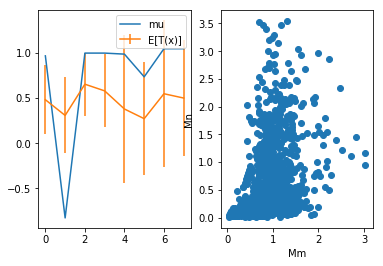

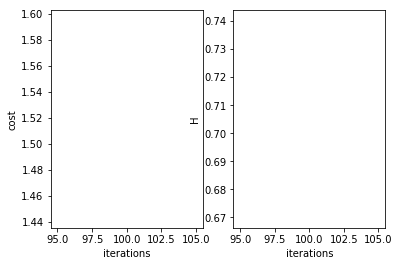

saving to results/LRRNN//tb/rank1_rnn_D=2_T=10_flow=4P_lr_order=-3_c=0_rs=0/  ...
******************************************
Doubling memory allocation for parameter logging.
******************************************
it = 200 
H 1.159337127817369
cost -0.5314712115716081
rank1 RNN!


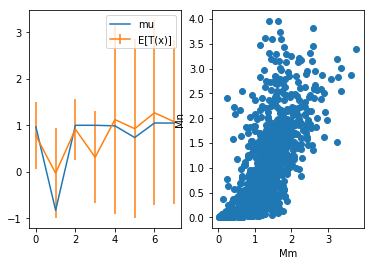

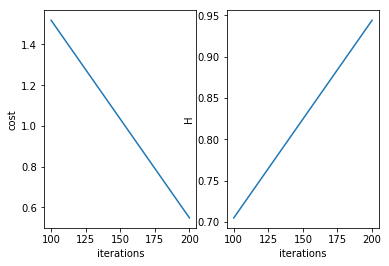

saving to results/LRRNN//tb/rank1_rnn_D=2_T=10_flow=4P_lr_order=-3_c=0_rs=0/  ...
******************************************


KeyboardInterrupt: 

In [10]:
Sigma = 0.05*np.ones((mu.shape[0],));
behavior = {'mu':mu, 'Sigma':Sigma};
print(behavior);
cost, phi, T_x = train_dsn(system, behavior, n, flow_dict, \
                       k_max=k_max, c_init_order=c_init_order, lr_order=lr_order,\
                       random_seed=random_seed, min_iters=min_iters, max_iters=max_iters, \
                       check_rate=check_rate, dir_str=dir_str);